# Prediccions tenint en compte només el ranquing

In [ ]:
import pandas as pd
import numpy as np

# Llegim el df

df = pd.read_csv('wimbeldon_dataset.csv')
df.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,DiffForm,DiffRest,LogRankDiff,H2HDiff,ProbA_odds,ProbB_odds,OddsProbDiff,WinRateA_x_Rank,WinRateB_x_Rank,EfficiencyDiff
0,36,London,Wimbledon,2025-07-13,Grand Slam,Outdoor,Grass,The Final,5.0,Sinner J.,...,0.2,0,0.693147,4,0.483092,0.534759,-0.051668,0.460526,0.736842,-0.276316
1,36,London,Wimbledon,2025-07-11,Grand Slam,Outdoor,Grass,Semifinals,5.0,Alcaraz C.,...,0.1,0,-0.916291,1,0.806452,0.190476,0.615975,0.459459,0.131429,0.328031
2,36,London,Wimbledon,2025-07-11,Grand Slam,Outdoor,Grass,Semifinals,5.0,Sinner J.,...,0.1,0,1.791759,0,0.327869,0.680272,-0.352403,0.145238,0.729730,-0.584492
3,36,London,Wimbledon,2025-07-09,Grand Slam,Outdoor,Grass,Quarterfinals,5.0,Sinner J.,...,-0.2,0,2.302585,-4,0.256410,0.746269,-0.489858,0.054545,0.722222,-0.667677
4,36,London,Wimbledon,2025-07-09,Grand Slam,Outdoor,Grass,Quarterfinals,5.0,Djokovic N.,...,-0.2,0,1.386294,-1,0.116279,0.892857,-0.776578,0.025000,0.145084,-0.120084


In [2]:
test = df.head(127)
train = df.iloc[127:]

Les dades de train les omitirem en aquest cas. Només ens quedarem les files de test.

#### Prediccions basades al ranking

Ara el que farem és donar com a guanyador al que tingui un ranking superior.

In [5]:
df_res = test[['Date', 'Round', 'PlayerA', 'PlayerB', 'RankA', 'RankB', 'RankDiff', 'WinnerBinary']]
df_res.head()

,Date,Round,PlayerA,PlayerB,RankA,RankB,RankDiff,WinnerBinary
0,2025-07-13,The Final,Alcaraz C.,Sinner J.,2.0,1.0,1.0,0
1,2025-07-11,Semifinals,Alcaraz C.,Fritz T.,2.0,5.0,-3.0,1
2,2025-07-11,Semifinals,Djokovic N.,Sinner J.,6.0,1.0,5.0,0
3,2025-07-09,Quarterfinals,Shelton B.,Sinner J.,10.0,1.0,9.0,0
4,2025-07-09,Quarterfinals,Cobolli F.,Djokovic N.,24.0,6.0,18.0,0


Apliquem un nou camp que sigui el guanyador segons la diferencia dels rankings.
- En cas de que **RankDiff** > 0, **WinnerByRank** = 0
- En cas de que **RankDiff** < 0, **WinnerByRank** = 1

In [7]:
df_res.loc[df_res['RankDiff'] > 0, 'WinnerByRank'] = 0
df_res.loc[df_res['RankDiff'] < 0, 'WinnerByRank'] = 1

df_res.head()

,Date,Round,PlayerA,PlayerB,RankA,RankB,RankDiff,WinnerBinary,WinnerByRank
0,2025-07-13,The Final,Alcaraz C.,Sinner J.,2.0,1.0,1.0,0,0.0
1,2025-07-11,Semifinals,Alcaraz C.,Fritz T.,2.0,5.0,-3.0,1,1.0
2,2025-07-11,Semifinals,Djokovic N.,Sinner J.,6.0,1.0,5.0,0,0.0
3,2025-07-09,Quarterfinals,Shelton B.,Sinner J.,10.0,1.0,9.0,0,0.0
4,2025-07-09,Quarterfinals,Cobolli F.,Djokovic N.,24.0,6.0,18.0,0,0.0


Ara que ja tenim el guanyador basat en el ranking, mirarem que tal li ha anat.

In [ ]:
df_res.loc[df_res['WinnerByRank'] == df_res['WinnerBinary'], 'CorrectByRank'] = 'Correct'
df_res.loc[df_res['WinnerByRank'] != df_res['WinnerBinary'], 'CorrectByRank'] = 'Incorrect'

df_res[['Round', 'CorrectByRank']].value_counts()

Round          CorrectByRank
1st Round      Correct          36
               Incorrect        28
2nd Round      Correct          22
3rd Round      Correct          11
2nd Round      Incorrect        10
4th Round      Correct           8
3rd Round      Incorrect         5
Quarterfinals  Correct           4
Semifinals     Correct           2
The Final      Correct           1
Name: count, dtype: int64

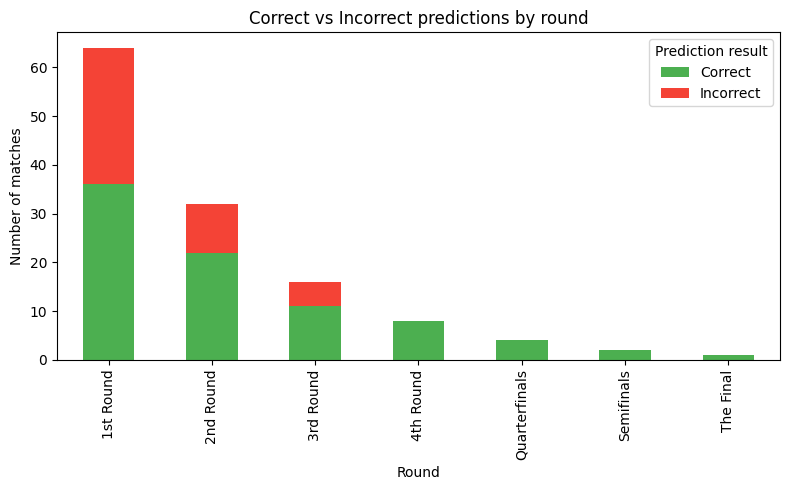

In [12]:
import matplotlib.pyplot as plt

# Counts per round and outcome
counts_by_round = (
    df_res
    .groupby(['Round', 'CorrectByRank'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Show the aggregated table
counts_by_round

# Stacked bar plot per round
ax = counts_by_round.plot(
    kind='bar',
    stacked=True,
    figsize=(8, 5),
    color={'Correct': '#4CAF50', 'Incorrect': '#F44336'}
)
ax.set_xlabel('Round')
ax.set_ylabel('Number of matches')
ax.set_title('Correct vs Incorrect predictions by round')
ax.legend(title='Prediction result')
plt.tight_layout()


In [13]:
df_res[['CorrectByRank']].value_counts()

CorrectByRank
Correct          84
Incorrect        43
Name: count, dtype: int64

Podem veure que, seguint l'instint de guiarnos per el que té el ranking més alt, no ha sortit gents malament.

Ens ha predit correctament uns 84 partits i uns 43 partits incorrectament. Dint-ho d'un altre manera, ha aconseguit predir correctament el **66.14%**.


Si ho comparem amb les prediccions d'IBM, aquesta no està molt allunyada, ja que IBM, amb el seu **66.93%** només aconsegueix millorar les prediccions en un 0.79%. Un número molt baix, tenint en compte que ho comparem amb un model tan primitiu com comparar els rankings de cada jugador.


---

#### Comparació del model per Ranking amb el d'IBM

Per fer-ho més visible, compararem de manera visual, les diferencies.

In [14]:
counts_by_round

CorrectByRank,Correct,Incorrect
Round,,
1st Round,36,28
2nd Round,22,10
3rd Round,11,5
4th Round,8,0
Quarterfinals,4,0
Semifinals,2,0
The Final,1,0


In [16]:
correct_ibm = [37, 22, 12, 8, 4, 2, 1]
incorrect_ibm = [(64-37), (32-22), (16-12), (8-8), (4-4), (2-2), (1-1)]

counts_by_round['CorrectIBM'] = correct_ibm
counts_by_round['IncorrectIBM'] = incorrect_ibm

counts_by_round

CorrectByRank,Correct,Incorrect,CorrectIBM,IncorrectIBM
Round,,,,
1st Round,36,28,37,27
2nd Round,22,10,22,10
3rd Round,11,5,12,4
4th Round,8,0,8,0
Quarterfinals,4,0,4,0
Semifinals,2,0,2,0
The Final,1,0,1,0


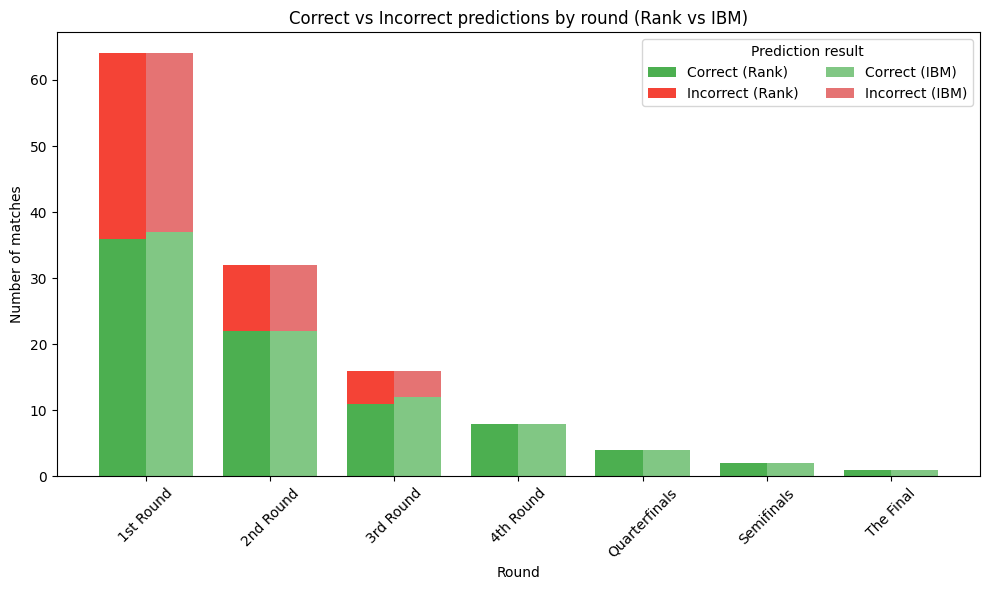

In [18]:
# Side-by-side stacked bars to compare Rank vs IBM predictions per round
labels = counts_by_round.index
x = np.arange(len(labels))
width = 0.38

rank_correct = counts_by_round['Correct']
rank_incorrect = counts_by_round['Incorrect']
ibm_correct = counts_by_round['CorrectIBM']
ibm_incorrect = counts_by_round['IncorrectIBM']

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, rank_correct, width, label='Correct (Rank)', color='#4CAF50')
ax.bar(x - width/2, rank_incorrect, width, bottom=rank_correct, label='Incorrect (Rank)', color='#F44336')
ax.bar(x + width/2, ibm_correct, width, label='Correct (IBM)', color='#81C784')
ax.bar(x + width/2, ibm_incorrect, width, bottom=ibm_correct, label='Incorrect (IBM)', color='#E57373')

ax.set_xlabel('Round')
ax.set_ylabel('Number of matches')
ax.set_title('Correct vs Incorrect predictions by round (Rank vs IBM)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend(title='Prediction result', ncol=2)
plt.tight_layout()


Com podem veure, no hi ha gaire diferencia entre els dos. IBM supera a aquest analisi més primitiu per només **2 prediccions**. D'aquí ve la poca diferencia que hi ha entre aquests dos.

---

#### Comparació amb el nostre model

_Coming soon..._